# No text features LSTM prediction

<ipython-input-1-6ce52392f951>:58: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["vol_z"].replace([np.inf, -np.inf], 0, inplace=True) # Replace Infs from x/0 (where x!=0)
<ipython-input-1-6ce52392f951>:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df

Starting training...
Epoch   1 | Train Loss 0.037865 | Val Loss 0.027955
Epoch   2 | Train Loss 0.022580 | Val Loss 0.019156
Epoch   3 | Train Loss 0.020320 | Val Loss 0.016546
Epoch   4 | Train Loss 0.018515 | Val Loss 0.007438
Epoch   5 | Train Loss 0.018199 | Val Loss 0.006851
Epoch   6 | Train Loss 0.017306 | Val Loss 0.010257
Epoch   7 | Train Loss 0.014836 | Val Loss 0.010167
Epoch   8 | Train Loss 0.017392 | Val Loss 0.010876
Epoch   9 | Train Loss 0.016540 | Val Loss 0.007382
Epoch  10 | Train Loss 0.014862 | Val Loss 0.006845
Epoch  11 | Train Loss 0.014788 | Val Loss 0.006915
Epoch  12 | Train Loss 0.014950 | Val Loss 0.007095
Epoch  13 | Train Loss 0.015604 | Val Loss 0.008484
Epoch  14 | Train Loss 0.015628 | Val Loss 0.006803
Epoch  15 | Train Loss 0.015460 | Val Loss 0.012700
Epoch  16 | Train Loss 0.016549 | Val Loss 0.006876
Epoch  17 | Train Loss 0.014845 | Val Loss 0.006968
Epoch  18 | Train Loss 0.014921 | Val Loss 0.007387
Epoch  19 | Train Loss 0.014644 | Val Loss 

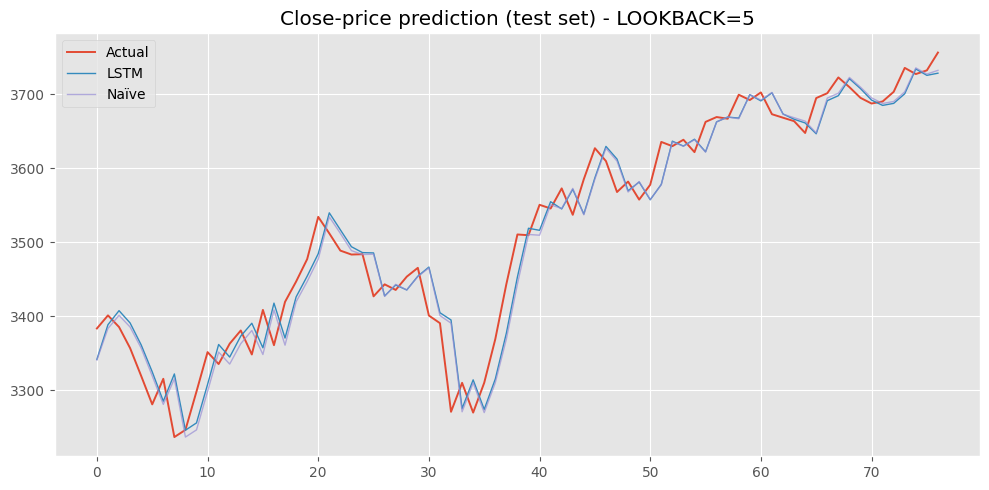

In [ ]:
# ------------------------- 1. Imports ---------------------------------------
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.style.use("ggplot")

# ------------------------- 2. Config ----------------------------------------
CSV_PATH   = Path("../../data/raw/StockEmotions/^GSPC.csv")
LOOKBACK = 5
TEST_RATIO = 0.33                      # 67 / 33 split (chronological)
HIDDEN     = 50
LAYERS     = 2
DROPOUT    = 0.10
BATCH_SIZE = 32
EPOCHS     = 300
LR         = 1e-3
PATIENCE   = 12
DEVICE     = "cuda" if torch.cuda.is_available() else "cpu"
SEED       = 42
torch.manual_seed(SEED); np.random.seed(SEED)

# ------------------------- 3. Load + Engineer Features ----------------------
df_orig = (pd.read_csv(CSV_PATH, parse_dates=["Date"])
        .sort_values("Date")
        .reset_index(drop=True))

# --- engineered columns (all computable with <= 3-day look-back) ------------
df = df_orig.copy()
df["ret1"]  = np.log(df["Close"] / df["Close"].shift(1))
df["ret2"]  = np.log(df["Close"] / df["Close"].shift(2))
df["ret3"]  = np.log(df["Close"] / df["Close"].shift(3))
df["range"] = (df["High"] - df["Low"]) / df["Close"]
df["co"]    = df["Close"] / df["Open"]
df["hc"]    = df["High"]  / df["Close"]
df["lc"]    = df["Low"]   / df["Close"]

# Robust vol_z calculation
df["vol_z_numerator"] = (df["Volume"] - df["Volume"].rolling(3).mean())
df["vol_z_denominator"] = df["Volume"].rolling(3).std()
df["vol_z"] = df["vol_z_numerator"] / df["vol_z_denominator"]
df["vol_z"].replace([np.inf, -np.inf], 0, inplace=True) # Replace Infs from x/0 (where x!=0)
df["vol_z"].fillna(0, inplace=True)                     # Replace NaNs (typically from 0/0)

feat_cols = ["Close","Open","High","Low","Volume",
             "ret1","ret2","ret3","range","co","hc","lc","vol_z"]

df = df.dropna().reset_index(drop=True) # drops rows with NaNs, mainly from shift() in returns

# -------------------------------- Corrected Scaling -----------------------------------
# --- Split data into train and test DataFrames FIRST ---
split_row = int(len(df) * (1 - TEST_RATIO))
df_train = df.iloc[:split_row].copy()
df_test  = df.iloc[split_row:].copy()

# --- Initialize scalers ---
scalers = {c: MinMaxScaler() for c in feat_cols}
F = len(feat_cols) # Number of features

# --- Scale Training Data ---
features_train_scaled = np.zeros((len(df_train), F), dtype=np.float32)
for i, col_name in enumerate(feat_cols):
    scaled_values = scalers[col_name].fit_transform(df_train[[col_name]])
    features_train_scaled[:, i] = scaled_values.flatten()
close_raw_train = df_train["Close"].values.reshape(-1,1).astype(np.float32)

# --- Scale Test Data ---
features_test_scaled = np.zeros((len(df_test), F), dtype=np.float32)
for i, col_name in enumerate(feat_cols):
    scaled_values = scalers[col_name].transform(df_test[[col_name]])
    features_test_scaled[:, i] = scaled_values.flatten()
close_raw_test = df_test["Close"].values.reshape(-1,1).astype(np.float32)

# ------------------------- 4. Build sequences -------------------------------
def make_sequences(feature_mat, close_price_vec, lookback):
    X_seq, y_target, last_price_for_pred = [], [], []
    for i in range(len(feature_mat) - lookback - 1):
        window = feature_mat[i : i + lookback]
        price_at_t   = close_price_vec[i + lookback]
        price_at_t1  = close_price_vec[i + lookback + 1]

        if price_at_t <= 0 or price_at_t1 <= 0: # Check for non-positive prices
            log_return_target = np.nan # Or some other placeholder like 0
        else:
            log_return_target = np.log(price_at_t1 / price_at_t)

        X_seq.append(window)
        y_target.append(log_return_target)
        last_price_for_pred.append(price_at_t)

    return (np.array(X_seq, dtype=np.float32),
            np.array(y_target, dtype=np.float32).reshape(-1,1),
            np.array(last_price_for_pred, dtype=np.float32).reshape(-1,1))

X_train, y_train, _             = make_sequences(features_train_scaled, close_raw_train, LOOKBACK)
X_test,  y_test,  last_p_test   = make_sequences(features_test_scaled,  close_raw_test,  LOOKBACK)

# Check for NaNs/Infs in targets
if np.any(np.isnan(y_train)):
    print(f"WARNING: {np.sum(np.isnan(y_train))} NaNs found in y_train. Consider handling them (e.g., fill with 0 or remove rows).")
    y_train = np.nan_to_num(y_train, nan=0.0) # Example: fill NaNs with 0
if np.any(np.isinf(y_train)):
    print(f"WARNING: {np.sum(np.isinf(y_train))} Infs found in y_train. Consider handling them.")
    y_train = np.nan_to_num(y_train, nan=0.0, posinf=np.finfo(np.float32).max, neginf=np.finfo(np.float32).min) # Example: clip

if np.any(np.isnan(y_test)):
    print(f"WARNING: {np.sum(np.isnan(y_test))} NaNs found in y_test.")
    y_test = np.nan_to_num(y_test, nan=0.0)
if np.any(np.isinf(y_test)):
    print(f"WARNING: {np.sum(np.isinf(y_test))} Infs found in y_test.")
    y_test = np.nan_to_num(y_test, nan=0.0, posinf=np.finfo(np.float32).max, neginf=np.finfo(np.float32).min)

# ------------------------- 5. Dataset & Loader ------------------------------
class PriceDS(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X)
        self.y = torch.tensor(y)
    def __len__(self):  return len(self.X)
    def __getitem__(self, i):
        return self.X[i], self.y[i].squeeze()

train_dl = DataLoader(PriceDS(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
test_dl  = DataLoader(PriceDS(X_test , y_test ), batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

# ------------------------- 6. Model ----------------------------------------
class BiTALSTM(nn.Module):
    def __init__(self, input_dim, hidden, layers, dropout):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden, num_layers=layers, dropout=dropout,
                            bidirectional=True, batch_first=True)
        hs = hidden*2
        self.Wq = nn.Linear(hs, hs)
        self.Wk = nn.Linear(hs, hs)
        self.v  = nn.Linear(hs, 1, bias=False)
        self.fc = nn.Linear(hs, 1)

    def forward(self, x):
        H, _ = self.lstm(x)
        q = self.Wq(H[:, -1])
        k = self.Wk(H)
        α = self.v(torch.tanh(k + q.unsqueeze(1)))
        α = torch.softmax(α, dim=1)
        ctx = torch.sum(α * H, dim=1)
        out = self.fc(ctx).squeeze(-1)
        return out, α.squeeze(-1)

model = BiTALSTM(F, HIDDEN, LAYERS, DROPOUT).to(DEVICE)

# ------------------------- 7. Training setup --------------------------------
loss_fn   = nn.SmoothL1Loss(beta=0.003)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=5e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=6, factor=0.5)

# ------------------------- 8. Train w/ early stopping -----------------------
best_val, wait = np.inf, 0
print("Starting training...")
for epoch in range(1, EPOCHS+1):
    model.train()
    train_loss_epoch = 0
    for xb, yb in train_dl:
        xb, yb = xb.to(DEVICE).float(), yb.to(DEVICE).float()
        pred,_ = model(xb)
        loss = loss_fn(pred, yb)
        if torch.isnan(loss): # Check for NaN loss
            print(f"WARNING: NaN loss encountered in training epoch {epoch}. Skipping batch.")
            continue
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        train_loss_epoch += loss.item() * xb.size(0)
    if len(train_dl.dataset) > 0 : train_loss_epoch /= len(train_dl.dataset)


    model.eval(); val_preds_list = []
    with torch.no_grad():
        for xb_val, _ in test_dl:
            xb_val = xb_val.to(DEVICE).float()
            p_val,_ = model(xb_val)
            val_preds_list.append(p_val.cpu())

    if not val_preds_list: # Handle empty test set if it occurs
        print(f"Epoch {epoch:3d} | Train Loss {train_loss_epoch:.6f} | Val Loss: N/A (empty test_dl)")
        if len(train_dl.dataset) == 0: break # Stop if no training data either
        continue

    val_preds = torch.cat(val_preds_list)
    y_test_tensor = torch.tensor(y_test.squeeze(), dtype=torch.float32)

    if val_preds.shape != y_test_tensor.shape:
        print(f"WARNING: Shape mismatch between val_preds {val_preds.shape} and y_test_tensor {y_test_tensor.shape}. Truncating...")
        min_len_val = min(val_preds.shape[0], y_test_tensor.shape[0])
        val_preds = val_preds[:min_len_val]
        y_test_tensor = y_test_tensor[:min_len_val]
        if min_len_val == 0:
            print("Validation set effectively empty after alignment. Skipping validation loss calc.")
            continue


    val_loss  = loss_fn(val_preds, y_test_tensor).item()
    if torch.isnan(torch.tensor(val_loss)):
        print(f"Epoch {epoch:3d} | Train Loss {train_loss_epoch:.6f} | Val Loss: NaN")
        # Optionally, decide how to handle NaN validation loss (e.g., stop training or use previous best)
    else:
        scheduler.step(val_loss)
        print(f"Epoch {epoch:3d} | Train Loss {train_loss_epoch:.6f} | Val Loss {val_loss:.6f}")

        if val_loss < best_val - 1e-7:
            best_val = val_loss; wait = 0
            torch.save(model.state_dict(), "best_talstm.pt")
        else:
            wait += 1
            if wait >= PATIENCE:
                print("Early stopping."); break
    if epoch % 20 == 0: print(f"Completed Epoch {epoch}")


# ------------------------- 9. Evaluation ------------------------------------
print("Loading best model for evaluation...")
model.load_state_dict(torch.load("best_talstm.pt"))
model.eval()
preds_list = []
with torch.no_grad():
    for xb_eval,_ in test_dl:
        xb_eval = xb_eval.to(DEVICE).float()
        p_eval,_ = model(xb_eval)
        preds_list.append(p_eval.cpu().numpy())

if not preds_list:
    print("ERROR: No predictions were generated from the test set. Metrics cannot be computed.")
    exit()

pred_ret = np.concatenate(preds_list)

# --- Debug: Check pred_ret for NaNs/Infs ---
if np.any(np.isnan(pred_ret)):
    print(f"WARNING: {np.sum(np.isnan(pred_ret))} NaNs found in pred_ret (model output). Replacing with 0 for metric calculation.")
    pred_ret = np.nan_to_num(pred_ret, nan=0.0)
if np.any(np.isinf(pred_ret)):
    print(f"WARNING: {np.sum(np.isinf(pred_ret))} Infs found in pred_ret (model output). Clipping for metric calculation.")
    pred_ret = np.nan_to_num(pred_ret, posinf=1.0, neginf=-1.0) # Example: clip large log-returns

# ---------------------------------------------------------------------------
# 9. Invert log-returns & compute metrics
# ---------------------------------------------------------------------------
last_p_vec = last_p_test.reshape(-1)
y_test_vec = y_test.reshape(-1)
pred_ret_flat = pred_ret.reshape(-1)

min_len = min(len(last_p_vec), len(y_test_vec), len(pred_ret_flat))
if min_len == 0:
    print("ERROR: Not enough data to compute metrics (min_len is 0).")
    exit()

last_p_vec = last_p_vec[:min_len]
y_test_vec = y_test_vec[:min_len]
pred_ret_final = pred_ret_flat[:min_len]

true_price = last_p_vec * np.exp(y_test_vec)
pred_price = last_p_vec * np.exp(pred_ret_final)

# --- Corrected NaN/Inf handling for pred_price using boolean indexing ---
nan_mask_price = np.isnan(pred_price)
if np.any(nan_mask_price):
    print(f"INFO: Replacing {np.sum(nan_mask_price)} NaNs in pred_price with corresponding last_p_vec values.")
    pred_price[nan_mask_price] = last_p_vec[nan_mask_price]

inf_mask_price = np.isinf(pred_price)
if np.any(inf_mask_price):
    print(f"INFO: Replacing {np.sum(inf_mask_price)} Infs in pred_price with corresponding last_p_vec values.")
    pred_price[inf_mask_price] = last_p_vec[inf_mask_price]

# Final fallback if last_p_vec also had NaNs at those spots or if pred_price is still problematic
pred_price = np.nan_to_num(pred_price, nan=np.nanmedian(true_price) if np.any(true_price) else 0,
                           posinf=np.nanmax(true_price) if np.any(true_price) else 1e9,
                           neginf=np.nanmin(true_price) if np.any(true_price) else -1e9)


mse_naive = mean_squared_error(true_price, last_p_vec)
mae_naive = mean_absolute_error(true_price, last_p_vec)

mse_lstm  = mean_squared_error(true_price, pred_price)
mae_lstm  = mean_absolute_error(true_price, pred_price)

print("\n----- TEST METRICS -----")
print(f"Naïve  MSE: {mse_naive:,.2f} | MAE: {mae_naive:,.2f}")
print(f"LSTM   MSE: {mse_lstm:,.2f} | MAE: {mae_lstm:,.2f}")

# ------------------------- 10. Plot ----------------------------------------
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(true_price)), true_price, label="Actual", linewidth=1.4)
plt.plot(np.arange(len(pred_price)), pred_price, label="LSTM", linewidth=1) # Use consistent x-axis
plt.plot(np.arange(len(last_p_vec)), last_p_vec, label="Naïve", linewidth=1, alpha=0.7)
plt.title(f"Close-price prediction (test set) - LOOKBACK={LOOKBACK}")
plt.legend(); plt.tight_layout(); plt.show()

# LSTM with text features

In [ ]:
# 1 ───────────────────────────────────────────────────────────────────────────
import numpy as np, pandas as pd, matplotlib.pyplot as plt, os
from pathlib import Path
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sentence_transformers import SentenceTransformer
from umap import UMAP
from sklearn.model_selection import TimeSeriesSplit

plt.style.use("ggplot")

# ─── CONFIG ────────────────────────────────────────────────────────────────
PRICE_CSV   = Path("../../data/raw/StockEmotions/^GSPC.csv")
TWEET_CSV   = Path("../../data/raw/StockEmotions/processed_stockemo.csv")
LOOKBACK    = 5
TEST_RATIO  = 0.33
HIDDEN      = 50
LAYERS      = 2
DROPOUT     = 0.10
BATCH_SIZE  = 32
EPOCHS      = 300
LR          = 1e-3
PATIENCE    = 12
DEVICE      = "cuda" if torch.cuda.is_available() else "cpu"
RAND        = 42
torch.manual_seed(RAND); np.random.seed(RAND)


In [ ]:
# 2 ───────────────────────────────────────────────────────────────────────────
tweets = (pd.read_csv(TWEET_CSV).rename(columns=str.lower))
tweets["date"] = pd.to_datetime(tweets["date"]).dt.normalize()
tweets["bull"] = (tweets["senti_label"] == "Bullish").astype(int)

# FinBERT embeddings → 2-D UMAP geometry
encoder = SentenceTransformer("yiyanghkust/finbert-tone")
emb     = encoder.encode(tweets["processed"].tolist(), show_progress_bar=True)   # 768-d

tscv = TimeSeriesSplit(n_splits=5)
train_idx, _ = list(tscv.split(emb))[-1]   # leakage-safe fit
umap  = UMAP(n_neighbors=10, n_components=2, min_dist=0.0,
             metric="cosine", random_state=RAND)
umap.fit(emb[train_idx])
tweets[["u0", "u1"]] = umap.transform(emb)

# daily aggregates + sentiment/UMAP lags + z-score
daily = (tweets.groupby("date")
               .agg(bull_ratio=("bull","mean"),
                    u0=("u0","mean"), u1=("u1","mean")))
for k in [1,2,3,5]:
    daily[[f"bull_lag{k}", f"u0_lag{k}", f"u1_lag{k}"]] = \
        daily[["bull_ratio","u0","u1"]].shift(k)
roll = daily["bull_ratio"].rolling(5, min_periods=5)
daily["bull_z5"] = (daily["bull_ratio"] - roll.mean()) / roll.std(ddof=0)
daily = daily.dropna()


Batches:   0%|          | 0/1572 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# 3 ───────────────────────────────────────────────────────────────────────────
px = (pd.read_csv(PRICE_CSV, parse_dates=["Date"])
        .sort_values("Date")
        .set_index("Date"))

# log returns + handcrafted technicals (≤3-day look-back)
px["ret_log"] = np.log(px["Close"] / px["Close"].shift(1))
px["ret1"]  = np.log(px["Close"] / px["Close"].shift(1))
px["ret2"]  = np.log(px["Close"] / px["Close"].shift(2))
px["ret3"]  = np.log(px["Close"] / px["Close"].shift(3))
px["range"] = (px["High"]-px["Low"])/px["Close"]
px["co"]    = px["Close"]/px["Open"]
px["hc"]    = px["High"]/px["Close"]
px["lc"]    = px["Low"]/px["Close"]
px["vol_z"] = (px["Volume"]-px["Volume"].rolling(3).mean())/px["Volume"].rolling(3).std()
px["vol_z"].replace([np.inf,-np.inf],0,inplace=True); px["vol_z"].fillna(0,inplace=True)
px = px.dropna()

# merge with tweet features
df = (px.join(daily, how="inner").dropna()).reset_index(drop=True)


<ipython-input-13-196aa2af74f2>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  px["vol_z"].replace([np.inf,-np.inf],0,inplace=True); px["vol_z"].fillna(0,inplace=True)


In [ ]:
# 4 ───────────────────────────────────────────────────────────────────────────
price_cols = ["Close","Open","High","Low","Volume",
              "ret1","ret2","ret3","range","co","hc","lc","vol_z"]
text_cols  = [c for c in daily.columns]      # all engineered tweet columns
feat_price = price_cols
feat_full  = price_cols + text_cols

# split index
split = int(len(df)*(1-TEST_RATIO))
df_tr, df_te = df.iloc[:split].copy(), df.iloc[split:].copy()

def scale_df(df_src, fit_df, cols):
    mat = np.zeros((len(df_src), len(cols)), dtype=np.float32)
    for i,col in enumerate(cols):
        scaler = MinMaxScaler().fit(fit_df[[col]])
        mat[:,i] = scaler.transform(df_src[[col]]).ravel()
    return mat

Xtr_price = scale_df(df_tr, df_tr, feat_price)
Xte_price = scale_df(df_te, df_tr, feat_price)        # fit on train only
Xtr_full  = scale_df(df_tr, df_tr, feat_full)
Xte_full  = scale_df(df_te, df_tr, feat_full)
Close_tr  = df_tr["Close"].values.astype(np.float32)
Close_te  = df_te["Close"].values.astype(np.float32)


In [ ]:
# 5 ───────────────────────────────────────────────────────────────────────────
def make_seq(Xmat, Close, lookback=LOOKBACK):
    Xseq, y, last = [], [], []
    for i in range(len(Xmat)-lookback-1):
        win = Xmat[i:i+lookback]
        p_t, p_t1 = Close[i+lookback], Close[i+lookback+1]
        y.append(np.log(p_t1/p_t))
        Xseq.append(win); last.append(p_t)
    return (np.array(Xseq,dtype=np.float32),
            np.array(y,dtype=np.float32).reshape(-1,1),
            np.array(last,dtype=np.float32).reshape(-1,1))

Xp_tr, yt_tr, _ = make_seq(Xtr_price, Close_tr)
Xp_te, yt_te, lp_te = make_seq(Xte_price, Close_te)
Xf_tr, yf_tr, _ = make_seq(Xtr_full , Close_tr)
Xf_te, yf_te, lp_tf= make_seq(Xte_full , Close_te)


In [ ]:
# 6 ───────────────────────────────────────────────────────────────────────────
class PriceDS(Dataset):
    def __init__(self,X,y): self.X,self.y=torch.tensor(X),torch.tensor(y)
    def __len__(self): return len(self.X)
    def __getitem__(self,i): return self.X[i], self.y[i].squeeze()

train_dl_p = DataLoader(PriceDS(Xp_tr,yt_tr),BATCH_SIZE,shuffle=True)
test_dl_p  = DataLoader(PriceDS(Xp_te,yt_te),BATCH_SIZE,shuffle=False)
train_dl_f = DataLoader(PriceDS(Xf_tr,yf_tr),BATCH_SIZE,shuffle=True)
test_dl_f  = DataLoader(PriceDS(Xf_te,yf_te),BATCH_SIZE,shuffle=False)

class BiTALSTM(nn.Module):
    def __init__(self,input_dim,hidden,layers,drop):
        super().__init__()
        self.lstm = nn.LSTM(input_dim,hidden,layers,
                            dropout=drop,bidirectional=True,batch_first=True)
        hs = hidden*2
        self.Wq,self.Wk = nn.Linear(hs,hs), nn.Linear(hs,hs)
        self.v  = nn.Linear(hs,1,bias=False)
        self.fc = nn.Linear(hs,1)
    def forward(self,x):
        H,_ = self.lstm(x)
        q = self.Wq(H[:,-1]); k = self.Wk(H)
        α = self.v(torch.tanh(k + q.unsqueeze(1)))
        α = torch.softmax(α,dim=1)
        ctx = torch.sum(α*H,dim=1)
        return self.fc(ctx).squeeze(-1), α.squeeze(-1)


In [ ]:
# 7 ───────────────────────────────────────────────────────────────────────────
def train_model(train_dl,test_dl,input_dim,label,name):
    model = BiTALSTM(input_dim,HIDDEN,LAYERS,DROPOUT).to(DEVICE)
    loss_fn = nn.SmoothL1Loss(beta=0.003)
    opt = torch.optim.Adam(model.parameters(),lr=LR,weight_decay=5e-5)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,patience=6,factor=0.5)
    best, wait = np.inf, 0
    for epoch in range(1,EPOCHS+1):
        model.train(); tl=0
        for xb,yb in train_dl:
            xb,yb = xb.to(DEVICE), yb.to(DEVICE)
            pred,_ = model(xb); loss = loss_fn(pred,yb)
            opt.zero_grad(); loss.backward(); opt.step()
            tl += loss.item()*xb.size(0)
        tl /= len(train_dl.dataset)
        model.eval(); preds=[]
        with torch.no_grad():
            for xb,_ in test_dl:
                preds.append(model(xb.to(DEVICE))[0].cpu())
        vl = loss_fn(torch.cat(preds), torch.tensor(label.squeeze())).item()
        sched.step(vl)
        if vl < best-1e-7: best, wait = vl,0; torch.save(model.state_dict(),f"best_{name}.pt")
        else: wait+=1;
        if wait>=PATIENCE: break
    model.load_state_dict(torch.load(f"best_{name}.pt"))
    return model


In [ ]:
# 8 ───────────────────────────────────────────────────────────────────────────
print("Training PRICE-ONLY LSTM …")
model_p = train_model(train_dl_p, test_dl_p, len(price_cols), yt_te, "price")

print("\nTraining PRICE+TEXT LSTM …")
model_f = train_model(train_dl_f, test_dl_f, len(feat_full), yf_te, "full")


Training PRICE-ONLY LSTM …

Training PRICE+TEXT LSTM …


In [ ]:
# 9 ───────────────────────────────────────────────────────────────────────────
def predict(model,test_dl):
    model.eval(); out=[]
    with torch.no_grad():
        for xb,_ in test_dl: out.append(model(xb.to(DEVICE))[0].cpu().numpy())
    return np.concatenate(out).ravel()

pred_p  = predict(model_p,test_dl_p)
pred_f  = predict(model_f,test_dl_f)

true_p  = lp_te.ravel()*np.exp(yt_te.ravel())
price_p = lp_te.ravel()*np.exp(pred_p)
price_f = lp_tf.ravel()*np.exp(pred_f)
naive   = lp_te.ravel()                        # random-walk close

def metrics(true,pred):
    return mean_squared_error(true,pred), mean_absolute_error(true,pred)

mse_nv, mae_nv = metrics(true_p, naive)
mse_p , mae_p  = metrics(true_p, price_p)
mse_f , mae_f  = metrics(true_p, price_f)

print("\n────────  TEST METRICS  ────────")
print(f"Naïve         MSE {mse_nv:,.2f} | MAE {mae_nv:,.2f}")
print(f"Price-only    MSE {mse_p :,.2f} | MAE {mae_p :,.2f}  "
      f"({100*(mae_nv-mae_p)/mae_nv:+.1f} % vs naïve)")
print(f"Price+TEXT    MSE {mse_f :,.2f} | MAE {mae_f :,.2f}  "
      f"({100*(mae_nv-mae_f)/mae_nv:+.1f} % vs naïve) "
      f"({100*(mae_p-mae_f)/mae_p:+.1f} % vs price)")



────────  TEST METRICS  ────────
Naïve         MSE 1,317.59 | MAE 28.77
Price-only    MSE 1,276.93 | MAE 28.42  (+1.2 % vs naïve)
Price+TEXT    MSE 1,187.72 | MAE 27.09  (+5.8 % vs naïve) (+4.7 % vs price)


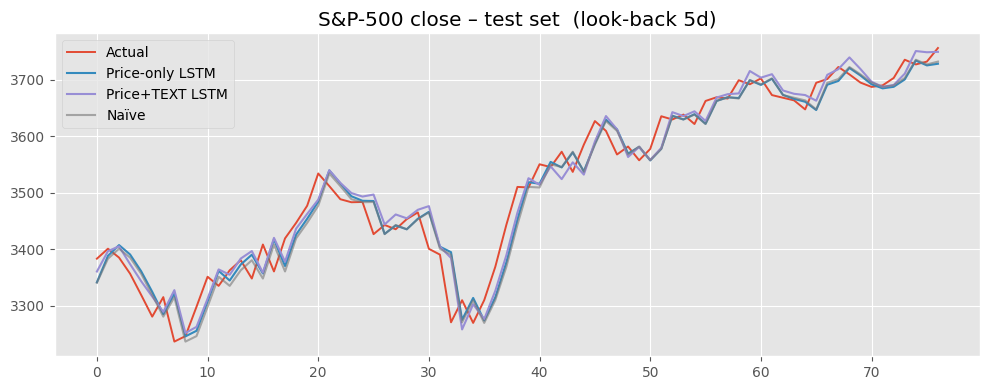

In [ ]:
# 10 ──────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(10,4))
plt.plot(true_p, label="Actual", linewidth=1.4)
plt.plot(price_p, label="Price-only LSTM")
plt.plot(price_f, label="Price+TEXT LSTM")
plt.plot(naive,   label="Naïve", alpha=0.6)
plt.title(f"S&P-500 close – test set  (look-back {LOOKBACK}d)")
plt.legend(); plt.tight_layout(); plt.show()


# Get text data

In [ ]:
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate
drive = None
def authenticate():
  global drive
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

#Download files
def downloadFiles(fileIds):
  authenticate()
  for fileId in fileIds:
    downloaded = drive.CreateFile({"id": fileId[1]})
    downloaded.GetContentFile(fileId[0])


In [ ]:
import os
import csv
import numpy as np
import pandas as pd

In [ ]:
# File download

downloadFiles([["train_stockemo.csv", "14kpQhdpjt57ySe9omZSofbmFF4iYUIDc"]])
downloadFiles([["val_stockemo.csv", "1-8FC0f1RDCNSkRt8doTDMAPrmdmazQ5u"]])
downloadFiles([["test_stockemo.csv", "1-A1n7mRMbje-me1rQpce_QsfFnlH0av7"]])
downloadFiles([["processed_stockemo.csv", "1-7QLxjVIezZLJ_Og5m3DmmW32BabnH2i"]])

In [ ]:
train_df = pd.read_csv("train_stockemo.csv", encoding="utf-8")

train_df.describe()

,id
count,8000.000000
mean,104051.056250
std,2340.437526
min,100001.000000
25%,102031.750000
50%,104050.500000
75%,106059.250000
max,109840.000000


In [ ]:
val_df = pd.read_csv("val_stockemo.csv", encoding="utf-8")
val_df

,id,date,ticker,emo_label,senti_label,original,processed
0,100595,2020-02-06,TSLA,anger,bearish,$TSLA did jim Cramer just pull another bear St...,Tesla did jim Cramer just pull another bear St...
1,100693,2020-02-11,FB,anger,bearish,$FB uh oh FTC turning up the heat 💩,Facebook uh oh FTC turning up the heat [pile ...
2,101203,2020-03-04,AAPL,anger,bullish,$AAPL why are they holding it here! WTF! ✌🏽 GL...,Apple why are they holding it here! WTF! [vic...
3,101223,2020-03-05,MSFT,belief,bullish,$MSFT 🍀🍀Target $200.00 long term ☀️☀️☀️☀️☀️,Microsoft [four leaf clover] Target $200.00 ...
4,101349,2020-03-11,AMZN,anger,bullish,$AMZN another RED day... thus is just plain ou...,Amazon another RED day... thus is just plain o...
...,...,...,...,...,...,...,...
995,108995,2020-12-31,TSLA,disgust,bullish,$TSLA What’s twice as good as $420? —————> $840 😎,Tesla What’s twice as good as $420? —————> $84...
996,108996,2020-12-31,FB,anxiety,bearish,$FB We’ll that’s some options fuckery by insti...,Facebook We’ll that’s some options fuckery by ...
997,108997,2020-12-31,TSLA,optimism,bullish,$TSLA the daily looks like a big ✅ check mark!...,Tesla the daily looks like a big [check mark ...
998,108998,2020-12-31,BA,optimism,bullish,"$BA this will pump when you least expect it, r...",Boeing this will pump when you least expect it...


In [ ]:
test_df = pd.read_csv("test_stockemo.csv", encoding="utf-8")
test_df

,id,date,ticker,emo_label,senti_label,original,processed
0,100067,2020-01-08,AAPL,confusion,bearish,$AAPL with all time highs again the market see...,Apple with all time highs again the market see...
1,100115,2020-01-10,BA,anxiety,bullish,$BA about to explode 🚨\nKeep shorting please,Boeing about to explode [police car light] \n...
2,100175,2020-01-15,SBUX,confusion,bearish,"$SBUX TPO alot of volume at 91.74, thats after...","Starbucks TPO alot of volume at 91.74, thats a..."
3,100234,2020-01-18,TSLA,confusion,bearish,$TSLA down 6$ afterhours right now 🤔,Tesla down 6$ afterhours right now [thinking ...
4,100268,2020-01-22,BA,confusion,bearish,$BA can someone tell me why they haven’t downg...,Boeing can someone tell me why they haven’t do...
...,...,...,...,...,...,...,...
995,109996,2020-12-31,ABNB,optimism,bearish,"$ABNB “sugar daddy puts.” Don’t mind me, I’m j...","Airbnb “sugar daddy puts.” Don’t mind me, I’m ..."
996,109997,2020-12-31,TSLA,disgust,bullish,$TSLA \nGood news... now bears can get help wh...,Tesla \nGood news... now bears can get help wh...
997,109998,2020-12-31,BABA,confusion,bullish,$BABA Who else is glad they sold in 240s yeste...,Alibaba Who else is glad they sold in 240s yes...
998,109999,2020-12-31,CCL,amusement,bullish,$CCL $23 calls for .79 you know what to do 🥳,Carnival $23 calls for .79 you know what to do...


In [ ]:
# load processed file

processed_df = pd.read_csv("processed_stockemo.csv", encoding="utf-8")
processed_df

,id,date,ticker,senti_label,original,processed,industry
0,0,2020-08-31,AAPL,Bullish,$AAPL you better get back to $130 again 🤔,AAPL you better get back to again thinking face,Information Technology
1,1,2020-08-31,AAPL,Bullish,$AAPL now we just wait for power hour 😎💪🏾,AAPL now we just wait for power hour smiling f...,Information Technology
2,2,2020-08-31,AAPL,Bullish,$AAPL never thought I'd buy this 💰,AAPL never thought I d buy this money bag,Information Technology
3,3,2020-08-31,AAPL,Bullish,$AAPL bought my first option ever with Apple f...,AAPL bought my first option ever with Apple fo...,Information Technology
4,4,2020-08-31,AAPL,Bullish,"$AAPL Buy low, hold for another split in a cou...",AAPL Buy low hold for another split in a coupl...,Information Technology
...,...,...,...,...,...,...,...
50276,50276,2020-10-08,LOW,Bullish,$LOW Why isn’t this trending yet 🤔,LOW Why isn t this trending yet thinking face,Consumer Discretionary
50277,50277,2020-10-08,LOW,Bullish,$LOW Show us some strength and push over $170‼️,LOW Show us some strength and push over double...,Consumer Discretionary
50278,50278,2020-11-11,LOW,Bullish,$LOW retail investors will keep adding until ...,LOW retail investors will keep adding until ea...,Consumer Discretionary
50279,50279,2020-12-09,LOW,Bullish,$LOW in 10mins Squeeze Zone possible morning s...,LOW in mins Squeeze Zone possible morning spik...,Consumer Discretionary


In [ ]:
%pip install -q transformers sentencepiece torch datasets evaluate scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 839.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.2 MB/s eta 0:00:00


# Check if the data is good

In [ ]:
import pandas as pd
import re

# Assuming train_df, val_df, test_df are loaded and have 'original' and 'processed' columns
dataframes = {'train': train_df, 'val': val_df, 'test': test_df}
sample_size = 5 # Check a few rows

for name, df in dataframes.items():
    print(f"\n--- Checking 'processed' column in {name}_df ---")
    if 'processed' not in df.columns:
        print(f"'processed' column not found in {name}_df.")
        continue

    # 1. Check for cashtag masking (e.g., presence of '$' vs. '[CTAG]')
    contains_dollar_sign = df['processed'].head(sample_size).str.contains(r'\$', regex=True).any()
    contains_ctag = df['processed'].head(sample_size).str.contains(r'\[CTAG\]', regex=True).any()
    print(f"Contains '$' in 'processed' (suggests cashtag NOT fully masked to [CTAG]): {contains_dollar_sign}")
    print(f"Contains '[CTAG]' in 'processed' (suggests cashtag masking occurred): {contains_ctag}")

    # 2. Check for emoji to text conversion (presence of common patterns like '[emoji_text]')
    contains_emoji_text = df['processed'].head(sample_size).str.contains(r'\[[a-zA-Z\s_]+\]', regex=True).any()
    print(f"Contains text like '[emoji_description]' (suggests emoji handling done): {contains_emoji_text}")

    # 3. Check for length filtering (presence of very short comments)
    short_comments = df['processed'].head(sample_size).apply(lambda x: len(str(x).split()) < 3).any()
    print(f"Contains very short comments (suggests NOT length filtered or short after processing): {short_comments}")
    print("Sample 'processed' texts:")
    print(df['processed'].head(sample_size).tolist())


--- Checking 'processed' column in train_df ---
Contains '$' in 'processed' (suggests cashtag NOT fully masked to [CTAG]): True
Contains '[CTAG]' in 'processed' (suggests cashtag masking occurred): False
Contains text like '[emoji_description]' (suggests emoji handling done): True
Contains very short comments (suggests NOT length filtered or short after processing): False
Sample 'processed' texts:
['Amazon Dow futures up by 100 points already  [partying face]', "Tesla Daddy's drinkin' eArly tonight! Here's to a PT of ohhhhh $1000 in 2020!  [clinking beer mugs]", 'Apple We’ll been riding since last December from $172.12 what to do. Decisions decisions hmm  [thinking face] . I have 20 mins to decide. Any suggestions?', 'Tesla happy new year, 2020, everyone [wine glass]  [party popper]  [folded hands] ', 'Tesla haha just a collection of greats..."Mars" rofl  [smiling face with horns]  [smiling face with sunglasses]  [shooting star]  [fast up button]  [crystal ball]  [money with wings]  [

# Need to mask cashtag tokens

In [ ]:
import pandas as pd
import re

# Assuming train_df, val_df, and test_df are already loaded
# and have the 'processed' column from the previous step.

def mask_cashtags(text):
    return re.sub(r'\$[A-Za-z0-9\._]+', '[CTAG]', str(text))

dataframes = {'train': train_df, 'val': val_df, 'test': test_df}
# Define regex patterns outside the f-string
dollar_pattern = r'\$'
ctag_pattern = r'\[CTAG\]'

for name, df in dataframes.items():
    if 'processed' in df.columns:
        print(f"\n--- Masking cashtags in {name}_df ---")
        df['processed_v2'] = df['processed'].apply(mask_cashtags)

        # Verify the change using the predefined patterns
        contains_dollar = df['processed_v2'].str.contains(dollar_pattern, regex=True).any()
        contains_ctag = df['processed_v2'].str.contains(ctag_pattern, regex=True).any()

        print(f"Contains '$' in 'processed_v2': {contains_dollar}")
        print(f"Contains '[CTAG]' in 'processed_v2': {contains_ctag}")
        print("Sample 'processed_v2' texts:")
        print(df['processed_v2'].head().tolist())

        # If you are happy with 'processed_v2', you can make it the main 'processed' column:
        df['processed'] = df['processed_v2']
        df.drop(columns=['processed_v2'], inplace=True) # Then drop the temporary column
    else:
        print(f"'processed' column not found in {name}_df.")


--- Masking cashtags in train_df ---
Contains '$' in 'processed_v2': True
Contains '[CTAG]' in 'processed_v2': True
Sample 'processed_v2' texts:
['Amazon Dow futures up by 100 points already  [partying face]', "Tesla Daddy's drinkin' eArly tonight! Here's to a PT of ohhhhh [CTAG] in 2020!  [clinking beer mugs]", 'Apple We’ll been riding since last December from [CTAG] what to do. Decisions decisions hmm  [thinking face] . I have 20 mins to decide. Any suggestions?', 'Tesla happy new year, 2020, everyone [wine glass]  [party popper]  [folded hands] ', 'Tesla haha just a collection of greats..."Mars" rofl  [smiling face with horns]  [smiling face with sunglasses]  [shooting star]  [fast up button]  [crystal ball]  [money with wings]  [clapping hands]  [flexed biceps]  [rocket]  [fireworks]  [sparkler]  [megaphone]  [party popper]  [confetti ball]  *bork*']

--- Masking cashtags in val_df ---
Contains '$' in 'processed_v2': True
Contains '[CTAG]' in 'processed_v2': True
Sample 'processed

# Fine tune bert for emotions

In [ ]:
!pip install --upgrade datasets transformers huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 73.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.0/510.0 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 53.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.31.4
    Uninstalling huggingface-hub-0.31.4:
      Successfully uninstalled huggingface-hub-0.31.4
  Attempting uninstall: transformers
    Found existing installation: transformers 4.52.2
    Uninstalling transformers-4.52.2:
      Successfully uninstalled transforme

In [ ]:
import pandas as pd
from datasets import Dataset, DatasetDict
import evaluate
from transformers import (
    DistilBertConfig,
    DistilBertForSequenceClassification,
    DistilBertTokenizerFast,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback,
)
from transformers.utils.notebook import NotebookProgressCallback

# --- CONFIGURATION FOR EMOTION CLASSIFICATION ---
NUM_EMOTION_LABELS = 12
EMOTION_OUTPUT_DIR = "checkpoints/emotion_classifier"
EMOTION_MODEL_SAVE_PATH = "saved_models/distilbert-stockemo-emotion"
# --- END CONFIGURATION ---

# Step 1: Load your CSVs (Assuming train_df, val_df, test_df are already loaded)
# train_df = pd.read_csv("train_stockemo.csv", encoding="utf-8")
# val_df   = pd.read_csv("val_stockemo.csv",   encoding="utf-8")
# test_df  = pd.read_csv("test_stockemo.csv",  encoding="utf-8")

# Step 1a: Create label mappings for emotions
# Extract unique emotion labels from the 'emo_label' column of your training data
# and ensure they match the ones in Table 5.
# For robustness, let's define them explicitly based on Table 5 to ensure order.
emotion_labels_from_table = [
    "ambiguous", "amusement", "anger", "anxiety", "belief",
    "confusion", "depression", "disgust", "excitement",
    "optimism", "panic", "surprise"
]
# Ensure your dataset's labels are a subset of these or match these exactly
# unique_emotions = sorted(train_df['emo_label'].unique()) # Alternative if you want to derive from data
# print(f"Unique emotions found in training data: {unique_emotions}")
# print(f"Number of unique emotions: {len(unique_emotions)}")


emo2id = {label: i for i, label in enumerate(emotion_labels_from_table)}
id2emo = {i: label for i, label in enumerate(emotion_labels_from_table)}

print(f"Emotion to ID mapping: {emo2id}")

# Step 1b: Convert pandas to HuggingFace DatasetDict
train_ds = Dataset.from_pandas(train_df)
val_ds   = Dataset.from_pandas(val_df)
test_ds  = Dataset.from_pandas(test_df)

raw_datasets_emotion = DatasetDict({
    "train":      train_ds,
    "validation": val_ds,
    "test":       test_ds,
})

# Step 2: Initialize Tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

def tokenize_fn(examples):
    return tokenizer(
        examples["processed"], # Assumes your processed text is in this column
        truncation=True,
        padding="max_length",
        max_length=512
    )

tokenized_datasets_emotion = raw_datasets_emotion.map(tokenize_fn, batched=True)

# Step 3: Encode emotion labels and set up torch format
def encode_emotions(examples):
    examples["labels"] = [emo2id[emotion] for emotion in examples["emo_label"]]
    return examples

tokenized_datasets_emotion = tokenized_datasets_emotion.map(encode_emotions, batched=True)

# Only keep the columns the model needs
# Note: removed "senti_label" if it was there, kept "emo_label" until encoding
columns_to_remove = ["id", "date", "ticker", "original", "processed", "emo_label"]
if "senti_label" in tokenized_datasets_emotion["train"].column_names: # If senti_label was also loaded
    columns_to_remove.append("senti_label")

tokenized_datasets_emotion = tokenized_datasets_emotion.remove_columns(columns_to_remove)
tokenized_datasets_emotion.set_format("torch")

# Step 4: Initialize model, Trainer, and metrics

# 4.1) Metrics
accuracy_metric = evaluate.load("accuracy")
f1_metric       = evaluate.load("f1")

def compute_emotion_metrics(pred):
    labels = pred.label_ids
    preds  = pred.predictions.argmax(-1)
    # For multi-class, macro F1 is often preferred if classes are imbalanced,
    # micro F1 is equivalent to accuracy. The paper reports "F1-score = 0.42" for emotion.
    # Let's use macro and micro to see.
    return {
        "accuracy":  accuracy_metric.compute(predictions=preds, references=labels)["accuracy"],
        "f1_macro":  f1_metric.compute(predictions=preds, references=labels, average="macro")["f1"],
        "f1_micro":  f1_metric.compute(predictions=preds, references=labels, average="micro")["f1"],
    }

# 4.2) Model + padding
emotion_config = DistilBertConfig.from_pretrained(
    "distilbert-base-uncased",
    num_labels=NUM_EMOTION_LABELS, # Changed to 12 for emotions
    classifier_dropout=0.2,       # As per paper's Table 6 for BERT-family
    id2label=id2emo,              # Optional: for better model introspection
    label2id=emo2id               # Optional: for better model introspection
)
emotion_model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    config=emotion_config
)
data_collator = DataCollatorWithPadding(tokenizer)

# 4.3) TrainingArguments
emotion_training_args = TrainingArguments(
    output_dir=EMOTION_OUTPUT_DIR,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=100,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3, # For experimentation, use 5 for closer replication to paper's DistilBERT epochs
    learning_rate=3e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1_macro", # Or "eval_f1_micro"
    greater_is_better=True,
    save_total_limit=2,
    disable_tqdm=False,
    report_to=[],
)

# 4.4) Trainer with callbacks
emotion_trainer = Trainer(
    model=emotion_model,
    args=emotion_training_args,
    train_dataset=tokenized_datasets_emotion["train"],
    eval_dataset=tokenized_datasets_emotion["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_emotion_metrics,
    callbacks=[
        NotebookProgressCallback(),
        EarlyStoppingCallback(early_stopping_patience=1) # Or 2, if training for more epochs
    ],
)

# Step 5: Train and evaluate
print("Starting emotion classifier training...")
emotion_trainer.train()
print("Emotion classifier training completed.")

print("Evaluating emotion classifier on validation set...")
eval_results = emotion_trainer.evaluate()
print(f"Validation results for emotion classifier: {eval_results}")

# Step 6: Predict on Test Set (for final metrics)
print("Predicting with emotion classifier on test set...")
test_predictions_emotion = emotion_trainer.predict(tokenized_datasets_emotion["test"])
print(f"Test metrics for emotion classifier: {test_predictions_emotion.metrics}")

# Step 7: Save the fine-tuned emotion model
print(f"Saving emotion classifier model to {EMOTION_MODEL_SAVE_PATH}...")
emotion_trainer.save_model(EMOTION_MODEL_SAVE_PATH)
tokenizer.save_pretrained(EMOTION_MODEL_SAVE_PATH) # Save tokenizer with the model
print("Emotion model saved.")

Emotion to ID mapping: {'ambiguous': 0, 'amusement': 1, 'anger': 2, 'anxiety': 3, 'belief': 4, 'confusion': 5, 'depression': 6, 'disgust': 7, 'excitement': 8, 'optimism': 9, 'panic': 10, 'surprise': 11}


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-13-9fe845bba1e1>:140: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  emotion_trainer = Trainer(
You are adding a <class 'transformers.utils.notebook.NotebookProgressCallback'> to the callbacks of this Trainer, but there is already one. The currentlist of callbacks is
:DefaultFlowCallback
NotebookProgressCallback
EarlyStoppingCallback


Starting emotion classifier training...


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Micro
1,1.851400,1.810376,0.378000,0.285634,0.378000
2,1.584100,1.698744,0.414000,0.349847,0.414000
3,1.392600,1.661080,0.431000,0.372328,0.431000


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Micro
1,1.851400,1.810376,0.378000,0.285634,0.378000
2,1.584100,1.698744,0.414000,0.349847,0.414000
3,1.392600,1.661080,0.431000,0.372328,0.431000


Emotion classifier training completed.
Evaluating emotion classifier on validation set...


Validation results for emotion classifier: {'eval_loss': 1.6610798835754395, 'eval_accuracy': 0.431, 'eval_f1_macro': 0.37232821365869984, 'eval_f1_micro': 0.431, 'eval_runtime': 14.8541, 'eval_samples_per_second': 67.322, 'eval_steps_per_second': 2.154, 'epoch': 3.0}
Predicting with emotion classifier on test set...
Test metrics for emotion classifier: {'test_loss': 1.6815241575241089, 'test_accuracy': 0.433, 'test_f1_macro': 0.3578722838786599, 'test_f1_micro': 0.433, 'test_runtime': 15.1398, 'test_samples_per_second': 66.051, 'test_steps_per_second': 2.114}
Saving emotion classifier model to saved_models/distilbert-stockemo-emotion...
Emotion model saved.


# Generate emotion embeddings

In [ ]:
import pandas as pd
import torch
from transformers import (
    DistilBertForSequenceClassification,
    DistilBertTokenizerFast,
)
from datasets import Dataset
from tqdm.auto import tqdm # For progress bar

# --- Configuration ---
EMOTION_MODEL_PATH = "saved_models/distilbert-stockemo-emotion" # Path where your emotion model is saved
TEXT_COLUMN = "processed" # Column in your DataFrames with the processed text
BATCH_SIZE = 64 # Batch size for inference, adjust based on your GPU memory

# --- Load DataFrames (ensure these are your original DataFrames with all necessary columns) ---
# train_df = pd.read_csv("train_stockemo.csv", encoding="utf-8")
# val_df   = pd.read_csv("val_stockemo.csv",   encoding="utf-8")
# test_df  = pd.read_csv("test_stockemo.csv",  encoding="utf-8")
# all_df combines them to predict emotions for all texts that will be part of time series
# Or, if you intend to use these splits distinctly for creating time series later,
# you might process them separately. For now, let's assume we want predictions for all.
# Ensure to handle duplicates if concatenating dfs that might have overlaps
# For simplicity, let's process them as they are and add a new column.

dataframes_to_process = {
    "train": train_df,
    "validation": val_df,
    "test": test_df
}

# --- Load Fine-tuned Emotion Classifier and Tokenizer ---
print(f"Loading emotion model from: {EMOTION_MODEL_PATH}")
emotion_model = DistilBertForSequenceClassification.from_pretrained(EMOTION_MODEL_PATH)
emotion_tokenizer = DistilBertTokenizerFast.from_pretrained(EMOTION_MODEL_PATH)

# --- Set up device (GPU if available) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
emotion_model.to(device)
emotion_model.eval() # Set model to evaluation mode
print(f"Using device: {device}")

# --- Function to get emotion predictions ---
def predict_emotions_for_df(df, text_column):
    texts = df[text_column].tolist()
    predicted_emotion_indices = []

    print(f"Predicting emotions for {len(texts)} texts...")
    for i in tqdm(range(0, len(texts), BATCH_SIZE)):
        batch_texts = texts[i:i+BATCH_SIZE]
        inputs = emotion_tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=128, # Use the same max_length as during emotion model training
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            logits = emotion_model(**inputs).logits
            predictions = torch.argmax(logits, dim=-1)
            predicted_emotion_indices.extend(predictions.cpu().tolist())

    return predicted_emotion_indices

# --- Generate and add emotion predictions to each DataFrame ---
for df_name, df_object in dataframes_to_process.items():
    print(f"\nProcessing DataFrame: {df_name}")
    predicted_indices = predict_emotions_for_df(df_object, TEXT_COLUMN)
    df_object['predicted_emotion_index'] = predicted_indices

    # You can also map back to emotion labels for verification if you have id2emo
    # if 'id2emo' in globals() or 'id2emo' in locals(): # Check if id2emo is defined
    #    df_object['predicted_emotion_label'] = [id2emo[idx] for idx in predicted_indices]
    #    print(df_object[['processed', 'emo_label', 'predicted_emotion_label', 'predicted_emotion_index']].head())
    # else:
    print(df_object[[TEXT_COLUMN, 'emo_label', 'predicted_emotion_index']].head())


print("\n--- Emotion Prediction Step Completed ---")
# Now, train_df, val_df, and test_df have a new column 'predicted_emotion_index'.
# This column contains the integer (0-11) representing the predicted emotion for each text.
# These indices will be the input to an nn.Embedding layer in your LSTM model to get Ee.

# Example: Display some results from train_df
print("\nSample of train_df with predicted emotion indices:")
print(train_df[[TEXT_COLUMN, 'emo_label', 'predicted_emotion_index']].head())

Loading emotion model from: saved_models/distilbert-stockemo-emotion
Using device: cuda

Processing DataFrame: train
Predicting emotions for 8000 texts...


  0%|          | 0/125 [00:00<?, ?it/s]

                                           processed   emo_label  \
0  Amazon Dow futures up by 100 points already  [...  excitement   
1  Tesla Daddy's drinkin' eArly tonight! Here's t...  excitement   
2  Apple We’ll been riding since last December fr...   confusion   
3  Tesla happy new year, 2020, everyone [wine gla...  excitement   
4  Tesla haha just a collection of greats..."Mars...  excitement   

   predicted_emotion_index  
0                        1  
1                        8  
2                        5  
3                        8  
4                        8  

Processing DataFrame: validation
Predicting emotions for 1000 texts...


  0%|          | 0/16 [00:00<?, ?it/s]

                                           processed emo_label  \
0  Tesla did jim Cramer just pull another bear St...     anger   
1  Facebook uh oh FTC turning up the heat  [pile ...     anger   
2  Apple why are they holding it here! WTF!  [vic...     anger   
3  Microsoft  [four leaf clover]  Target [CTAG] l...    belief   
4  Amazon another RED day... thus is just plain o...     anger   

   predicted_emotion_index  
0                        2  
1                        2  
2                        9  
3                        4  
4                        2  

Processing DataFrame: test
Predicting emotions for 1000 texts...


  0%|          | 0/16 [00:00<?, ?it/s]

                                           processed  emo_label  \
0  Apple with all time highs again the market see...  confusion   
1  Boeing about to explode  [police car light] \n...    anxiety   
2  Starbucks TPO alot of volume at 91.74, thats a...  confusion   
3  Tesla down 6$ afterhours right now  [thinking ...  confusion   
4  Boeing can someone tell me why they haven’t do...  confusion   

   predicted_emotion_index  
0                        5  
1                        3  
2                        5  
3                        5  
4                        3  

--- Emotion Prediction Step Completed ---

Sample of train_df with predicted emotion indices:
                                           processed   emo_label  \
0  Amazon Dow futures up by 100 points already  [...  excitement   
1  Tesla Daddy's drinkin' eArly tonight! Here's t...  excitement   
2  Apple We’ll been riding since last December fr...   confusion   
3  Tesla happy new year, 2020, everyone [wine gla...  ex

# Generate sentence embeddings

In [ ]:
import pandas as pd
import torch
from transformers import DistilBertModel, DistilBertTokenizerFast
from tqdm.auto import tqdm
import numpy as np

# --- Configuration ---
BASE_MODEL_NAME = "distilbert-base-uncased" # Using the same base as your classifiers
TEXT_COLUMN = "processed" # Column with the processed text
BATCH_SIZE_EMBEDDING = 32 # Batch size for generating embeddings, adjust based on GPU memory

# --- Assume train_df, val_df, test_df are already loaded and have the 'processed' column ---
# And they also have 'predicted_emotion_index' from the previous step.

# dataframes_to_process = { # This was defined in the previous step, ensure it's still available
#     "train": train_df,
#     "validation": val_df,
#     "test": test_df
# }

# --- Load Base DistilBERT Model and Tokenizer ---
print(f"Loading base model for sentence embeddings: {BASE_MODEL_NAME}")
sentence_tokenizer = DistilBertTokenizerFast.from_pretrained(BASE_MODEL_NAME)
sentence_model = DistilBertModel.from_pretrained(BASE_MODEL_NAME)

# --- Set up device (GPU if available) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sentence_model.to(device)
sentence_model.eval() # Set model to evaluation mode
print(f"Using device: {device} for sentence embeddings")

# --- Function to get sentence embeddings ---
def get_sentence_embeddings_for_df(df, text_column_name):
    texts = df[text_column_name].tolist()
    all_embeddings = []

    print(f"Generating sentence embeddings for {len(texts)} texts...")
    for i in tqdm(range(0, len(texts), BATCH_SIZE_EMBEDDING)):
        batch_texts = texts[i:i+BATCH_SIZE_EMBEDDING]
        inputs = sentence_tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=512, # Using 512 as per paper's BERT max_length for general processing
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            outputs = sentence_model(**inputs)
            # We'll use the embedding of the [CLS] token (first token) as the sentence representation
            # The output `last_hidden_state` has shape (batch_size, sequence_length, hidden_size)
            cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            all_embeddings.extend(cls_embeddings)

    return np.array(all_embeddings)

# --- Generate and add sentence embeddings to each DataFrame ---
for df_name, df_object in dataframes_to_process.items(): # Assuming dataframes_to_process is still defined
    print(f"\nGenerating sentence embeddings for DataFrame: {df_name}")
    sentence_embeddings = get_sentence_embeddings_for_df(df_object, TEXT_COLUMN)
    # Store embeddings as a list of arrays/lists in the DataFrame column,
    # or handle them separately if memory is a concern for very large DataFrames.
    # For simplicity, adding as a new column where each entry is the embedding array.
    df_object['sentence_embedding_Se'] = list(sentence_embeddings) # Store as list of numpy arrays

    print(f"Shape of sentence embeddings for {df_name}: ({len(df_object)}, {df_object['sentence_embedding_Se'].iloc[0].shape[0]})")
    print(df_object[[TEXT_COLUMN, 'sentence_embedding_Se']].head())

print("\n--- Sentence Embedding Generation (Step 2) Completed ---")
# Now, train_df, val_df, and test_df have a new column 'sentence_embedding_Se'.
# Each entry in this column is a NumPy array representing the sentence embedding.

# Example: Display some results from train_df
print("\nSample of train_df with sentence embeddings:")
print(train_df[[TEXT_COLUMN, 'predicted_emotion_index', 'sentence_embedding_Se']].head())
# Verify the type and shape of one embedding
if not train_df.empty and 'sentence_embedding_Se' in train_df.columns:
    print(f"Type of one embedding: {type(train_df['sentence_embedding_Se'].iloc[0])}")
    print(f"Shape of one embedding: {train_df['sentence_embedding_Se'].iloc[0].shape}")

Loading base model for sentence embeddings: distilbert-base-uncased
Using device: cuda for sentence embeddings

Generating sentence embeddings for DataFrame: train
Generating sentence embeddings for 8000 texts...


  0%|          | 0/250 [00:00<?, ?it/s]

Shape of sentence embeddings for train: (8000, 768)
                                           processed  \
0  Amazon Dow futures up by 100 points already  [...   
1  Tesla Daddy's drinkin' eArly tonight! Here's t...   
2  Apple We’ll been riding since last December fr...   
3  Tesla happy new year, 2020, everyone [wine gla...   
4  Tesla haha just a collection of greats..."Mars...   

                               sentence_embedding_Se  
0  [-0.22065829, -0.17245497, 0.1486197, -0.01895...  
1  [0.028945608, 0.032819077, 0.112325706, -0.276...  
2  [0.06627994, -0.12558253, 0.023428213, -0.2782...  
3  [-0.039465774, -0.14902316, 0.23794591, -0.125...  
4  [-0.08015248, -0.20550238, -0.09222335, -0.125...  

Generating sentence embeddings for DataFrame: validation
Generating sentence embeddings for 1000 texts...


  0%|          | 0/32 [00:00<?, ?it/s]

Shape of sentence embeddings for validation: (1000, 768)
                                           processed  \
0  Tesla did jim Cramer just pull another bear St...   
1  Facebook uh oh FTC turning up the heat  [pile ...   
2  Apple why are they holding it here! WTF!  [vic...   
3  Microsoft  [four leaf clover]  Target [CTAG] l...   
4  Amazon another RED day... thus is just plain o...   

                               sentence_embedding_Se  
0  [-0.0023532077, 0.039339855, -0.25736633, -0.1...  
1  [0.04701251, -0.058917258, -0.05963785, -0.248...  
2  [-0.1938777, -0.11371288, -0.115092106, -0.296...  
3  [-0.3463137, -0.20728514, -0.19548877, -0.2012...  
4  [0.001365356, -0.05927677, -0.16719903, -0.345...  

Generating sentence embeddings for DataFrame: test
Generating sentence embeddings for 1000 texts...


  0%|          | 0/32 [00:00<?, ?it/s]

Shape of sentence embeddings for test: (1000, 768)
                                           processed  \
0  Apple with all time highs again the market see...   
1  Boeing about to explode  [police car light] \n...   
2  Starbucks TPO alot of volume at 91.74, thats a...   
3  Tesla down 6$ afterhours right now  [thinking ...   
4  Boeing can someone tell me why they haven’t do...   

                               sentence_embedding_Se  
0  [-0.0023790249, -0.03416557, -0.017628478, -0....  
1  [-0.05730101, -0.1301422, 0.10026266, -0.16853...  
2  [-0.2525736, -0.06560554, 0.05924984, -0.19966...  
3  [-0.097907975, 0.045848228, 0.036161285, -0.10...  
4  [0.058667365, 0.0050122347, -0.11121058, -0.09...  

--- Sentence Embedding Generation (Step 2) Completed ---

Sample of train_df with sentence embeddings:
                                           processed  predicted_emotion_index  \
0  Amazon Dow futures up by 100 points already  [...                        1   
1  Tesla Daddy's

# Check the data distribution

Loading data...
Calculating sentiment features...
Merging data and preparing target...
Shape of data for analysis: (253, 16)

Plotting Histograms of Sentiment Features...


<ipython-input-24-cf2c65a9ec4f>:97: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_merged[col] = df_merged[col].fillna(method='ffill')
<ipython-input-24-cf2c65a9ec4f>:98: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_merged[col] = df_merged[col].fillna(method='bfill')


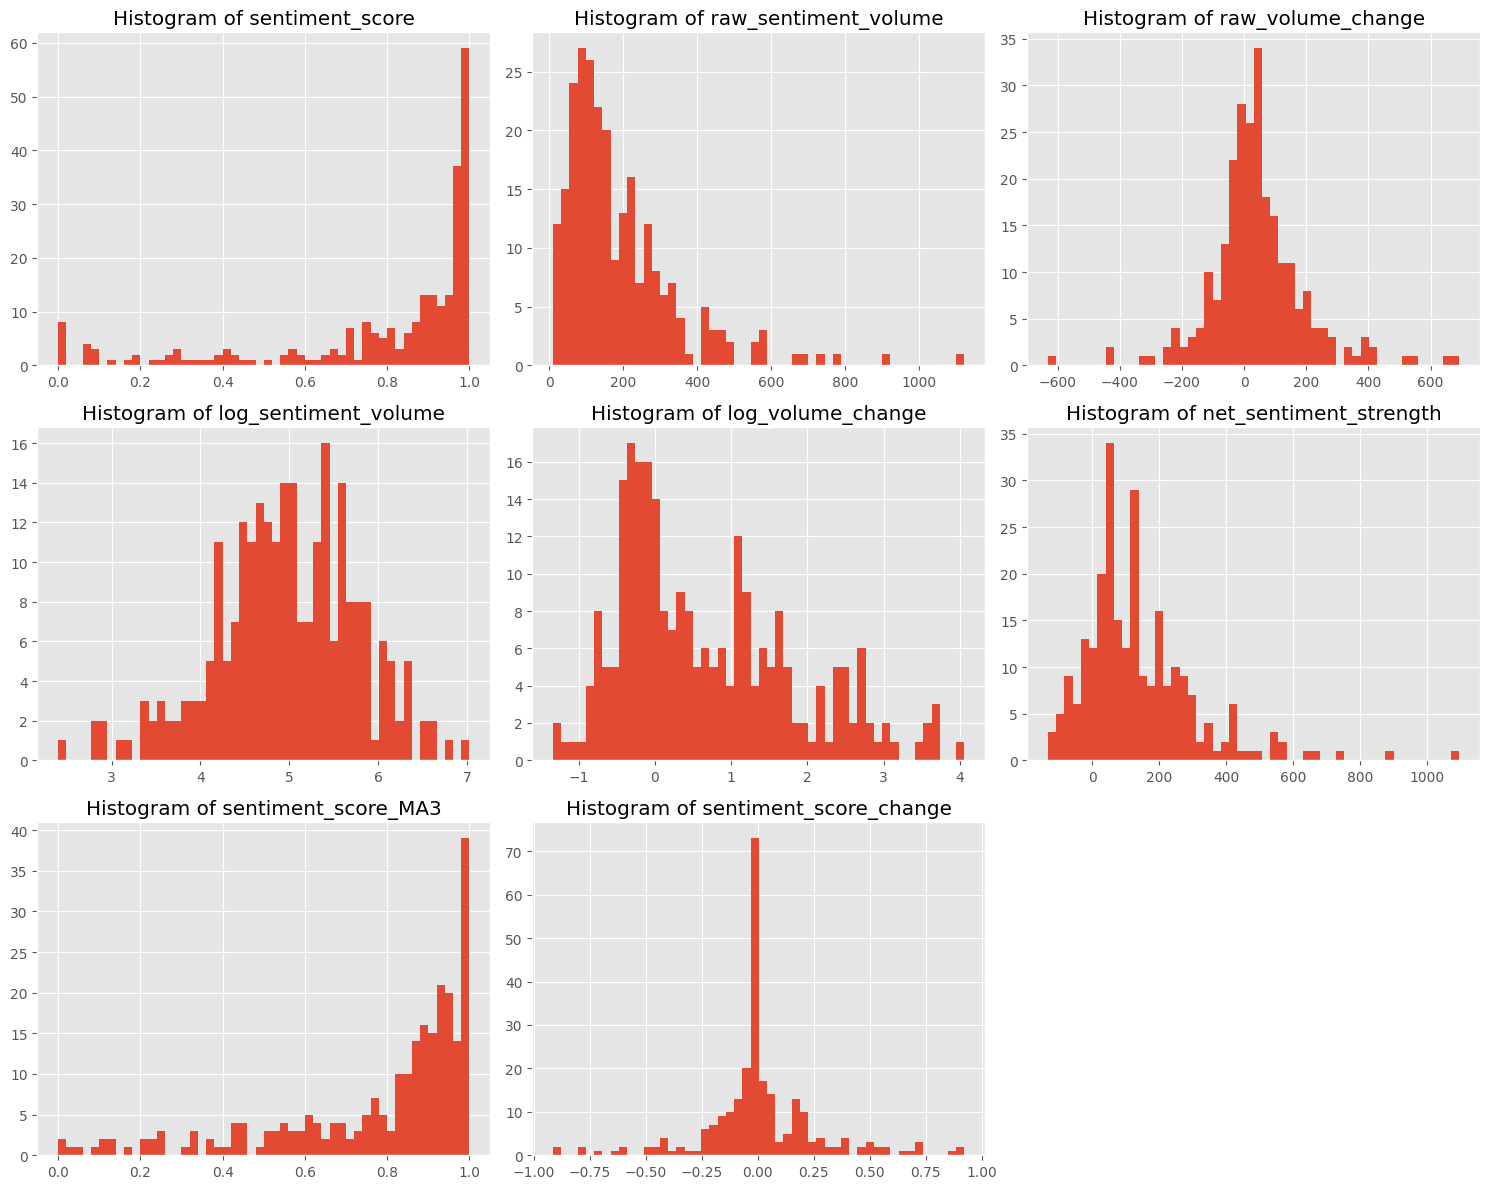


Plotting Scatter Plots vs. Target Log Return...


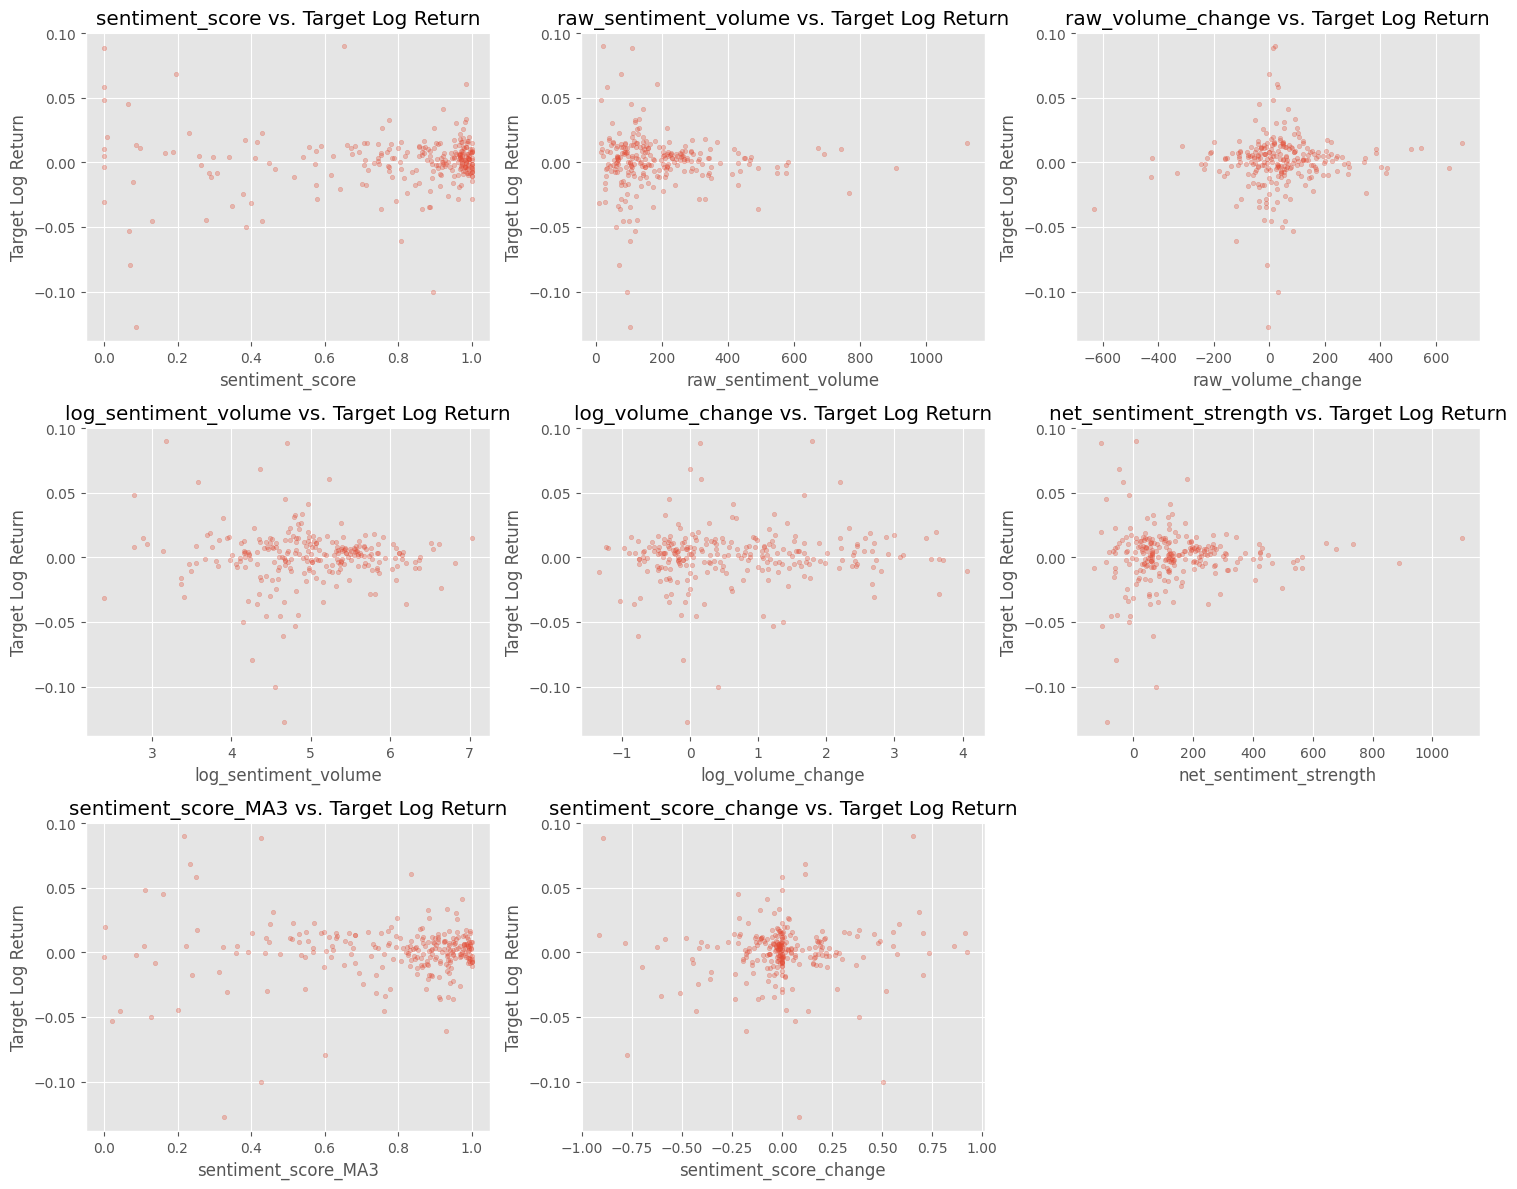


Plotting Correlation Heatmap...


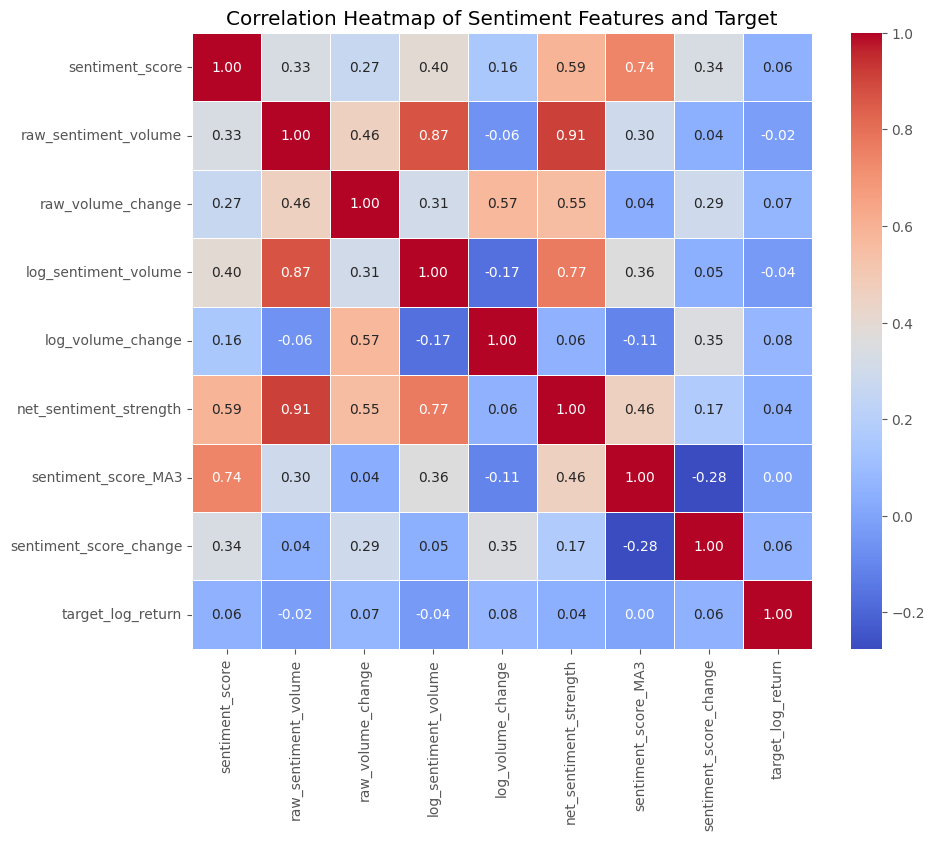


Plotting Time Series Overlay Example...


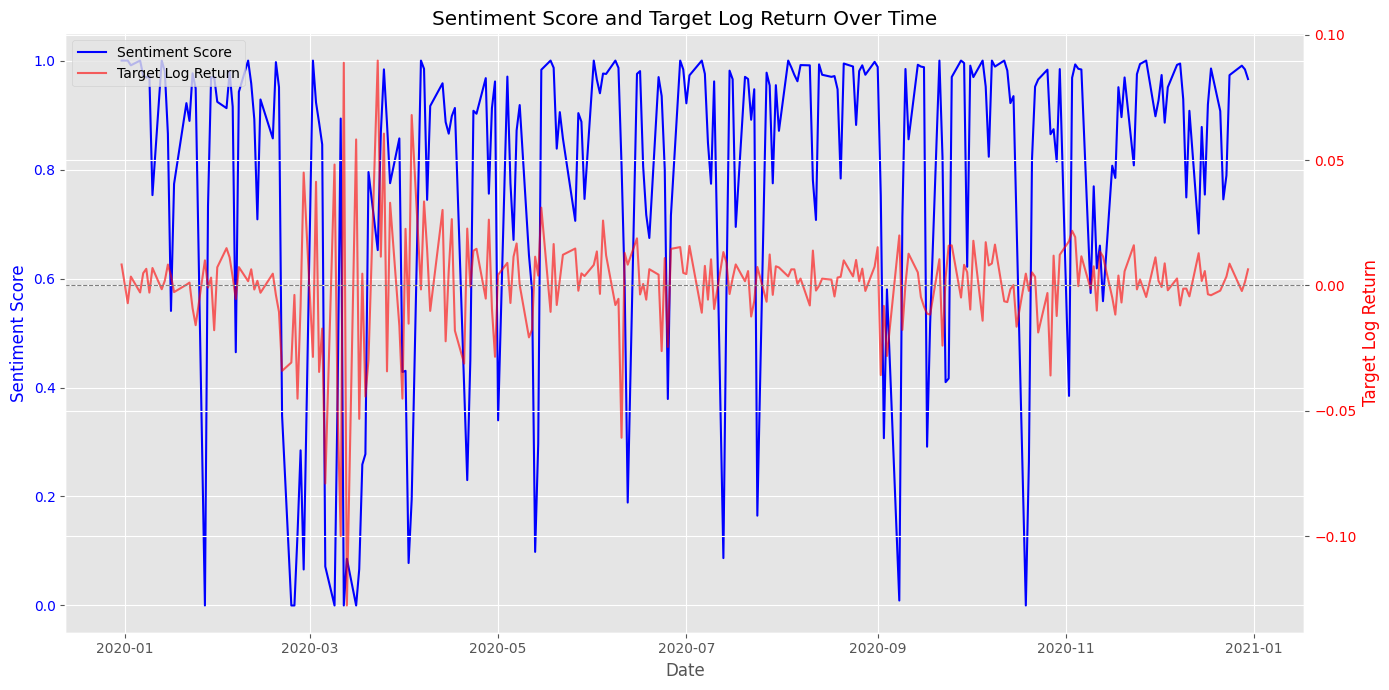


Analysis plots generated.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # For heatmap
from pathlib import Path

# --- Configuration ---
STOCK_CSV_PATH = Path("^GSPC.csv")
SENTIMENT_CSV_PATH = Path("processed_stockemo.csv")
plt.style.use("ggplot")

# --- 1. Load Data ---
print("Loading data...")
try:
    df_stock = pd.read_csv(STOCK_CSV_PATH, parse_dates=["Date"]).sort_values("Date").reset_index(drop=True)
except FileNotFoundError:
    print(f"Error: Stock data file '{STOCK_CSV_PATH}' not found.")
    exit()

try:
    sentiment_raw_df = pd.read_csv(SENTIMENT_CSV_PATH, encoding="utf-8", parse_dates=['date'])
except FileNotFoundError:
    print(f"Error: Sentiment data file '{SENTIMENT_CSV_PATH}' not found.")
    # Create an empty df to avoid errors if we want to proceed with partial analysis
    sentiment_raw_df = pd.DataFrame(columns=['date', 'senti_label'])
    sentiment_raw_df['date'] = pd.to_datetime(sentiment_raw_df['date'])


# --- 2. Calculate Sentiment Features ---
print("Calculating sentiment features...")
if not sentiment_raw_df.empty and 'date' in sentiment_raw_df.columns and 'senti_label' in sentiment_raw_df.columns:
    daily_counts = sentiment_raw_df.groupby('date')['senti_label'].value_counts().unstack(fill_value=0)

    if 'Bullish' not in daily_counts.columns: daily_counts['Bullish'] = 0
    if 'Bearish' not in daily_counts.columns: daily_counts['Bearish'] = 0

    # Base metrics
    raw_sentiment_volume_series = daily_counts['Bullish'] + daily_counts['Bearish']
    log_sentiment_volume_series = np.log1p(raw_sentiment_volume_series)

    sentiment_analysis_df = pd.DataFrame(index=daily_counts.index)
    sentiment_analysis_df = sentiment_analysis_df.sort_index() # Ensure sorted index for diff/rolling

    # Feature: sentiment_score (Ratio)
    total_for_ratio = daily_counts['Bullish'] + daily_counts['Bearish']
    sentiment_analysis_df['sentiment_score'] = (daily_counts['Bullish'] / total_for_ratio).where(total_for_ratio > 0, 0.5)

    # Feature: raw_sentiment_volume
    sentiment_analysis_df['raw_sentiment_volume'] = raw_sentiment_volume_series

    # Feature: raw_volume_change
    sentiment_analysis_df['raw_volume_change'] = raw_sentiment_volume_series.sort_index().diff().fillna(0)

    # Feature: log_sentiment_volume
    sentiment_analysis_df['log_sentiment_volume'] = log_sentiment_volume_series

    # Feature: log_volume_change
    sentiment_analysis_df['log_volume_change'] = log_sentiment_volume_series.sort_index().diff().fillna(0)

    # Feature: net_sentiment_strength
    sentiment_analysis_df['net_sentiment_strength'] = daily_counts['Bullish'] - daily_counts['Bearish']

    # Feature: sentiment_score_MA3 (3-day Moving Average of sentiment_score)
    sentiment_analysis_df['sentiment_score_MA3'] = sentiment_analysis_df['sentiment_score'].rolling(window=3, min_periods=1).mean()

    # Feature: sentiment_score_change (Daily change in sentiment_score)
    sentiment_analysis_df['sentiment_score_change'] = sentiment_analysis_df['sentiment_score'].diff().fillna(0)

    sentiment_analysis_df = sentiment_analysis_df.reset_index()
    sentiment_analysis_df.rename(columns={'date': 'Date'}, inplace=True)
    sentiment_analysis_df['Date'] = pd.to_datetime(sentiment_analysis_df['Date'])
else:
    print("Sentiment data is empty or malformed. Creating empty sentiment feature DataFrame.")
    sentiment_analysis_df = pd.DataFrame(columns=[
        'Date', 'sentiment_score', 'raw_sentiment_volume', 'raw_volume_change',
        'log_sentiment_volume', 'log_volume_change', 'net_sentiment_strength',
        'sentiment_score_MA3', 'sentiment_score_change'
    ])
    sentiment_analysis_df['Date'] = pd.to_datetime(sentiment_analysis_df['Date'])

# --- 3. Merge and Prepare Target Variable ---
print("Merging data and preparing target...")
df_merged = pd.merge(df_stock, sentiment_analysis_df, on="Date", how="left")

# Fill NaNs for sentiment features that might arise from merge (e.g. stock trading days without sentiment)
# For analysis, ffill then bfill might be acceptable, or fill with a defined neutral value
sentiment_cols_to_fill = [
    'sentiment_score', 'raw_sentiment_volume', 'raw_volume_change',
    'log_sentiment_volume', 'log_volume_change', 'net_sentiment_strength',
    'sentiment_score_MA3', 'sentiment_score_change'
]
for col in sentiment_cols_to_fill:
    if col in df_merged.columns:
        neutral_value = 0.5 if 'score' in col else 0 # General neutral values
        if col == 'sentiment_score_MA3': neutral_value = 0.5 # For MA of score

        df_merged[col] = df_merged[col].fillna(method='ffill')
        df_merged[col] = df_merged[col].fillna(method='bfill')
        df_merged[col] = df_merged[col].fillna(neutral_value) # Fill any remaining start/end NaNs

# Calculate target: next-day log return
df_merged['target_log_return'] = np.log(df_merged['Close'].shift(-1) / df_merged['Close'])

# Drop rows with NaNs that cannot be filled (especially the last row for target_log_return)
df_analysis = df_merged.dropna(subset=['target_log_return'] + sentiment_cols_to_fill).copy()

if df_analysis.empty:
    print("DataFrame for analysis is empty after merging and NaN handling. Check data processing steps.")
    exit()

print(f"Shape of data for analysis: {df_analysis.shape}")

# --- 4. Generate Plots ---
sentiment_features_to_plot = [
    'sentiment_score', 'raw_sentiment_volume', 'raw_volume_change',
    'log_sentiment_volume', 'log_volume_change', 'net_sentiment_strength',
    'sentiment_score_MA3', 'sentiment_score_change'
]

# Ensure all features to plot actually exist in df_analysis
sentiment_features_to_plot = [f for f in sentiment_features_to_plot if f in df_analysis.columns]

if not sentiment_features_to_plot:
    print("No sentiment features available for plotting. Exiting.")
    exit()

# Plot 1: Histograms of Sentiment Features
print("\nPlotting Histograms of Sentiment Features...")
n_features = len(sentiment_features_to_plot)
n_cols_hist = 3
n_rows_hist = (n_features + n_cols_hist - 1) // n_cols_hist # Calculate rows needed
plt.figure(figsize=(5 * n_cols_hist, 4 * n_rows_hist))
for i, feature in enumerate(sentiment_features_to_plot):
    plt.subplot(n_rows_hist, n_cols_hist, i + 1)
    df_analysis[feature].hist(bins=50)
    plt.title(f"Histogram of {feature}")
plt.tight_layout()
plt.show()

# Plot 2: Scatter Plots of Sentiment Features vs. Target Log Return
print("\nPlotting Scatter Plots vs. Target Log Return...")
plt.figure(figsize=(5 * n_cols_hist, 4 * n_rows_hist))
for i, feature in enumerate(sentiment_features_to_plot):
    plt.subplot(n_rows_hist, n_cols_hist, i + 1)
    plt.scatter(df_analysis[feature], df_analysis['target_log_return'], alpha=0.3, s=10)
    plt.title(f"{feature} vs. Target Log Return")
    plt.xlabel(feature)
    plt.ylabel("Target Log Return")
plt.tight_layout()
plt.show()

# Plot 3: Correlation Heatmap
print("\nPlotting Correlation Heatmap...")
features_for_corr = sentiment_features_to_plot + ['target_log_return']
correlation_matrix = df_analysis[features_for_corr].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap of Sentiment Features and Target")
plt.show()

# Plot 4: Time Series Overlay (Example: sentiment_score and target_log_return)
print("\nPlotting Time Series Overlay Example...")
if 'sentiment_score' in df_analysis.columns:
    plt.figure(figsize=(14, 7))

    ax1 = plt.gca()
    ax1.plot(df_analysis['Date'], df_analysis['sentiment_score'], color='blue', label='Sentiment Score')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Sentiment Score', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx() # instantiate a second axes that shares the same x-axis
    ax2.plot(df_analysis['Date'], df_analysis['target_log_return'], color='red', alpha=0.6, label='Target Log Return')
    ax2.set_ylabel('Target Log Return', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.axhline(0, color='gray', linestyle='--', linewidth=0.8) # Add a zero line for returns

    plt.title('Sentiment Score and Target Log Return Over Time')
    # Adding legends manually as twinx can be tricky
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')

    plt.tight_layout()
    plt.show()
else:
    print("Skipping time series overlay as 'sentiment_score' is not available.")

print("\nAnalysis plots generated.")